In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns
import glob
import os
import fnmatch
from scipy import stats
import math

In [2]:
# Generals
ldp = '/Users/sol/Documents/LargeData/' # data folder
months=['January','February','March','April','May','June','July','August','September','October','November','December']

# regional domain
ldom = np.array([[46.5,47.5],[-125.1,-124]])
# QIN domain
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 

sns.set(style="whitegrid")
#palette=plt.get_cmap("Spectral").reversed()
#palette=plt.get_cmap("YlGnBu").reversed()
#palette=plt.get_cmap("coolwarm").reversed()
palette=plt.get_cmap("RdYlGn")


In [40]:
fishdt = pd.read_csv('../data/QiN_dataspecifics.csv')
# https://docs.google.com/spreadsheets/d/1zYiVVgZR4DLksM_yABO_zPnsXe7Q6Uh_8tvxt3n60N0/edit?usp=sharing')
# Transform O2
fishdt['Om'] = fishdt['Om']/44.661
fishes=fishdt['Species']
fishdt

,Species,Dx,Dm,Tx,Tm,Om
0,Dungeness Crab,90,41,11.72,5.36,2.416202
1,Sablefish,1450,175,12.85,4.72,0.786592
2,P. Halibut,155,515,9.28,2.92,1.246501
3,Chinook,172,43,11.65,3.49,1.218513
4,Coho,118,28,12.35,4.43,2.110790
5,Razor Clams,28,5,12.73,5.99,2.472851
6,Albacore,0,400,19.40,12.20,3.232350


In [37]:
fishdt['Tx'][0]

11.72

In [3]:
fishes = ['Sablefish','Dungeness Crab','P. Halibut','Chinook','Coho','Razon Clams', 'Albacore']
var = ['thetao','o2']   
depth = ['surface','bottom']
ssps = ['ssp245','ssp585']
Trange = np.array([[4.72, 12.85],[5.36,11.72],[2.92,9.28],[3.49,11.65],[4.43,12.35],[5.99,12.73],[12.2,19.4]])
O2range = np.array([[35.13, 400],[107.91,400],[55.67,400],[54.42,400],[58.94,400],[110.44,400],[144.36,260.45]])
O2range = O2range/44.661  # conversion to ml/l
Deprange = np.array([[175, 1450],[41,90],[155,515],[43,172],[28,118],[5,28],[0,400]])

In [38]:
def T_weighted_suitable_habitat(fishnum):
    import math
    
    # define normal distribution for the t range and set values
    m = (fishdt['Tx'][fishnum]+fishdt['Tm'][fishnum])/2
    s = (fishdt['Tx'][fishnum]-fishdt['Tm'][fishnum])*0.68/2
    # scale to 0-1
    xw = np.arange(fishdt['Tm'][fishnum], fishdt['Tx'][fishnum], 0.01)
    z = 1/s/np.sqrt(2*math.pi)
    yw = z * np.exp(-0.5*((xw - m)/s)**2)
    ymin = yw.min()
    ymax = (yw-ymin).max()
    #ymax = yw.max()
    nyw = (yw-ymin)/ymax
    #plt.plot(xw, nyw)
    #plt.show()
    
    return xw, nyw
    

In [47]:
pdf_surf = pd.read_excel('../pdfs_downscaleddata/surface thetao_pdf.xlsx', index_col=0)
print(list(pdf_surf))
pdf_sthr = pd.read_excel('../pdfs_downscaleddata/surface thetao_thresholds.xlsx', index_col=0)
pdf_bott = pd.read_excel('../pdfs_downscaleddata/bottom thetao_pdf.xlsx', index_col=0)
pdf_bthr = pd.read_excel('../pdfs_downscaleddata/bottom thetao_thresholds.xlsx', index_col=0)
pdf_bthr

['obs_x', 'obs_y', 'p1_x_245', 'p1_y_245', 'p2_x_245', 'p2_y_245', 'p1_x_585', 'p1_y_585', 'p2_x_585', 'p2_y_585']


,obs_90,obs_10,p1_90_245,p1_10_245,p2_90_245,p2_10_245,p1_90_585,p1_10_585,p2_90_585,p2_10_585
0,9.249492,7.249047,9.117636,7.319918,10.060845,7.945522,9.117636,7.319918,10.060845,7.945522


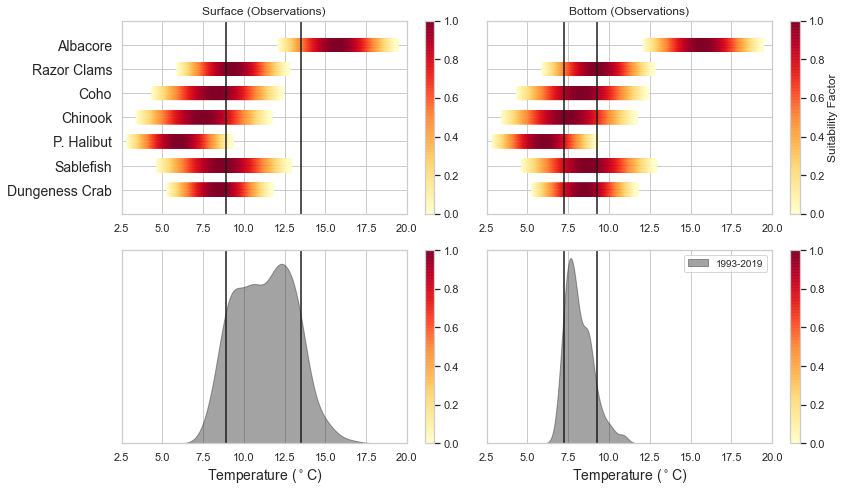

In [41]:
# observations
fig = plt.figure(figsize=(12,7))
sz = 40
offset = 0.1
cms = 'YlOrRd'
al = 0.8
lws = 1.5
c1 = 'k'
c2 = 'teal'

# surface 
plt.subplot(2,2,1)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_sthr['obs_90'].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['obs_10'].values,c=c1, ls='-', lw=lws)

plt.yticks(range(len(fishes)),fishes, fontsize=14)
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
plt.title('Surface (Observations)')

plt.subplot(2,2,3)
plt.fill_between(pdf_surf['obs_x'],pdf_surf['obs_y'],color=c1, alpha=0.4, label='1993-2019')
plt.axvline(pdf_sthr['obs_90'].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['obs_10'].values,c=c1, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.2])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
#plt.ylabel('PDF')

# bottom 
plt.subplot(2,2,2)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_bthr['obs_90'].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['obs_10'].values,c=c1, ls='-', lw=lws)

plt.yticks(range(len(fishes)),[])
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
cb.set_label('Suitability Factor' )
plt.title('Bottom (Observations)')

plt.subplot(2,2,4)
plt.fill_between(pdf_bott['obs_x'],pdf_bott['obs_y'],color=c1, alpha=0.4, label='1993-2019')
plt.axvline(pdf_bthr['obs_90'].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['obs_10'].values,c=c1, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.55])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
plt.legend(loc=0, fontsize='small')

plt.tight_layout()
plt.show()

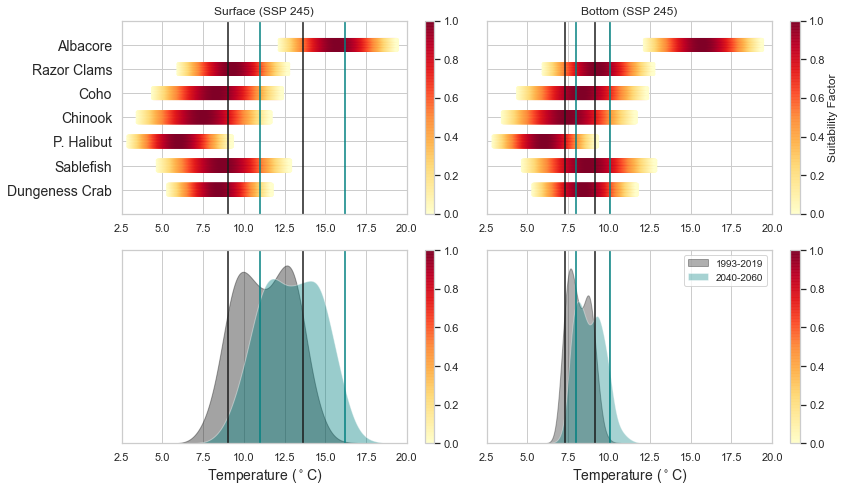

In [42]:

fig = plt.figure(figsize=(12,7))
sz = 40
offset = 0.1
cms = 'YlOrRd'
al = 0.8
lws = 1.5
c1 = 'k'
c2 = 'teal'
ssp='245'

# surface 
plt.subplot(2,2,1)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_sthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)

plt.yticks(range(len(fishes)),fishes, fontsize=14)
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
plt.title('Surface (SSP '+ssp+')')

plt.subplot(2,2,3)
plt.fill_between(pdf_surf['p1_x_'+ssp],pdf_surf['p1_y_'+ssp],color=c1, alpha=0.4, label='1993-2019')
plt.fill_between(pdf_surf['p2_x_'+ssp],pdf_surf['p2_y_'+ssp],fc=c2, ec='w', alpha=0.4, label='2040-2060')
plt.axvline(pdf_sthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.2])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
#plt.ylabel('PDF')

# bottom 
plt.subplot(2,2,2)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_bthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)

plt.yticks(range(len(fishes)),[])
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
cb.set_label('Suitability Factor' )
plt.title('Bottom (SSP '+ssp+')')

plt.subplot(2,2,4)
plt.fill_between(pdf_bott['p1_x_'+ssp],pdf_bott['p1_y_'+ssp],fc=c1, ec='k',alpha=0.35, label='1993-2019')
plt.fill_between(pdf_bott['p2_x_'+ssp],pdf_bott['p2_y_'+ssp],fc=c2, ec='w',alpha=0.35, label='2040-2060')
plt.axvline(pdf_bthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.55])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
plt.legend(loc=0, fontsize='small')

plt.tight_layout()
plt.show()

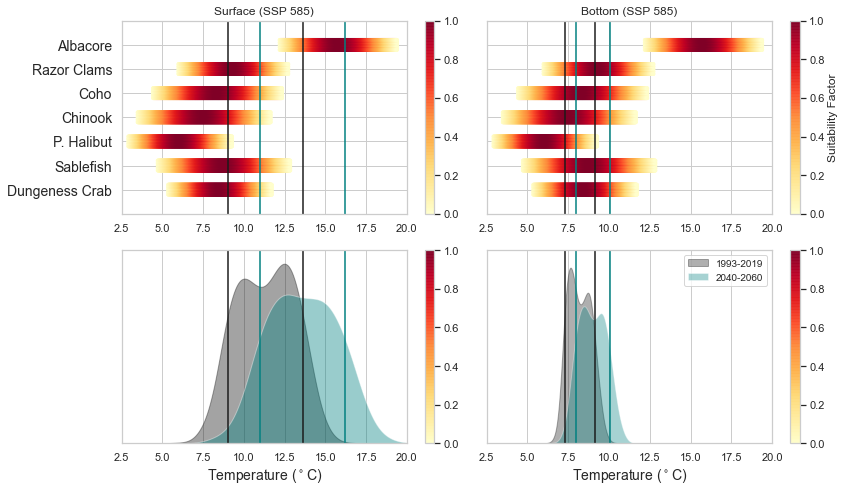

In [43]:

fig = plt.figure(figsize=(12,7))
sz = 40
offset = 0.1
cms = 'YlOrRd'
al = 0.8
lws = 1.5
c1 = 'k'
c2 = 'teal'
ssp='585'

# surface 
plt.subplot(2,2,1)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_sthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)

plt.yticks(range(len(fishes)),fishes, fontsize=14)
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
plt.title('Surface (SSP '+ssp+')')

plt.subplot(2,2,3)
plt.fill_between(pdf_surf['p1_x_'+ssp],pdf_surf['p1_y_'+ssp],color=c1, alpha=0.4, label='1993-2019')
plt.fill_between(pdf_surf['p2_x_'+ssp],pdf_surf['p2_y_'+ssp],fc=c2, ec='w', alpha=0.4, label='2040-2060')
plt.axvline(pdf_sthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_sthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.2])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
#plt.ylabel('PDF')

# bottom 
plt.subplot(2,2,2)
for fishn in range(len(fishes)):
    x,y = T_weighted_suitable_habitat(fishn)
    y2 = np.full(len(x),fishn)
    plt.scatter(x,y2,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2+2*offset,sz,y,'.', cmap=cms, alpha=al)
    plt.scatter(x,y2-2*offset,sz,y,'.', cmap=cms, alpha=al)
    
plt.axvline(pdf_bthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)

plt.yticks(range(len(fishes)),[])
plt.ylim([-1,len(fishes)])
plt.xlim([2.5, 20])
cb = plt.colorbar()
cb.set_label('Suitability Factor' )
plt.title('Bottom (SSP '+ssp+')')

plt.subplot(2,2,4)
plt.fill_between(pdf_bott['p1_x_'+ssp],pdf_bott['p1_y_'+ssp],color=c1, alpha=0.35, label='1993-2019')
plt.fill_between(pdf_bott['p2_x_'+ssp],pdf_bott['p2_y_'+ssp],fc=c2, ec='w', alpha=0.35, label='2040-2060')
plt.axvline(pdf_bthr['p1_90_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['p1_10_'+ssp].values,c=c1, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_90_'+ssp].values,c=c2, ls='-', lw=lws)
plt.axvline(pdf_bthr['p2_10_'+ssp].values,c=c2, ls='-', lw=lws)
plt.colorbar(alpha=0)
plt.yticks([],[])
plt.xlim([2.5, 20])
plt.ylim([0,0.55])
plt.xlabel('Temperature ($^\circ$C)', fontsize=14)
plt.legend(loc=0, fontsize='small')

plt.tight_layout()
plt.show()

In [44]:
pdf_surf_o2 = pd.read_excel('../pdfs_downscaleddata/surface o2_pdf.xlsx', index_col=0)
print(list(pdf_surf_o2))
pdf_bott_o2 = pd.read_excel('../pdfs_downscaleddata/bottom o2_pdf.xlsx', index_col=0)

['obs_x', 'obs_y', 'p1_x_245', 'p1_y_245', 'p2_x_245', 'p2_y_245', 'p1_x_585', 'p1_y_585', 'p2_x_585', 'p2_y_585']


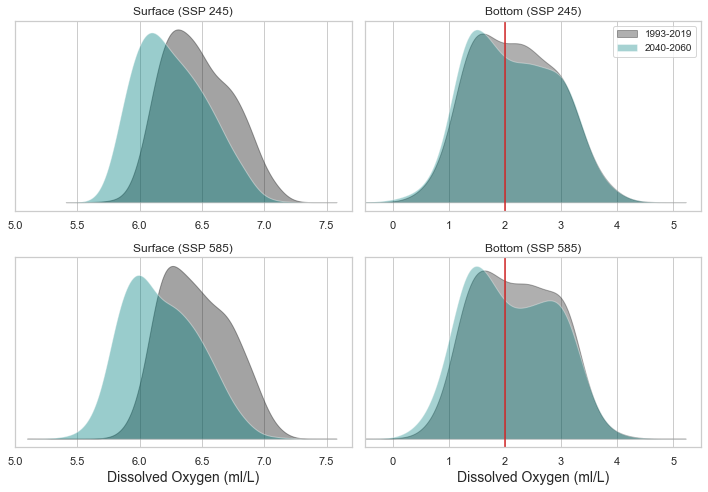

In [46]:
c3='tab:red'
c1='k'
fig = plt.figure(figsize=(10,7))
ssp='245'
plt.subplot(2,2,1)
plt.fill_between(pdf_surf_o2['p1_x_'+ssp],pdf_surf_o2['p1_y_'+ssp],color=c1, alpha=0.4, label='1993-2019')
plt.fill_between(pdf_surf_o2['p2_x_'+ssp],pdf_surf_o2['p2_y_'+ssp],fc=c2, ec='w', alpha=0.4, label='2040-2060')
#plt.axvline(1.5,c=c1, ls='-', lw=lws)
plt.yticks([],[])
plt.xlim([5, 7.7])
#plt.ylim([0,0.2])
plt.title('Surface (SSP '+ssp+')')
#plt.ylabel('PDF')

plt.subplot(2,2,2)
plt.fill_between(pdf_bott_o2['p1_x_'+ssp],pdf_bott_o2['p1_y_'+ssp],color=c1, alpha=0.35, label='1993-2019')
plt.fill_between(pdf_bott_o2['p2_x_'+ssp],pdf_bott_o2['p2_y_'+ssp],fc=c2, ec='w', alpha=0.35, label='2040-2060')
plt.axvline(2,c=c3, ls='-', lw=lws)
plt.yticks([],[])
plt.xlim([-0.5, 5.5])
#plt.ylim([0,0.55])
plt.title('Bottom (SSP '+ssp+')')
plt.legend(loc=0, fontsize='small')

ssp='585'
plt.subplot(2,2,3)
plt.fill_between(pdf_surf_o2['p1_x_'+ssp],pdf_surf_o2['p1_y_'+ssp],color=c1, alpha=0.4, label='1993-2019')
plt.fill_between(pdf_surf_o2['p2_x_'+ssp],pdf_surf_o2['p2_y_'+ssp],fc=c2, ec='w', alpha=0.4, label='2040-2060')
#plt.axvline(1.5,c=c1, ls='-', lw=lws)
plt.yticks([],[])
plt.xlim([5, 7.7])
#plt.ylim([0,0.2])
plt.title('Surface (SSP '+ssp+')')
plt.xlabel('Dissolved Oxygen (ml/L)', fontsize=14)
#plt.ylabel('PDF')

plt.subplot(2,2,4)
plt.fill_between(pdf_bott_o2['p1_x_'+ssp],pdf_bott_o2['p1_y_'+ssp],color=c1, alpha=0.35, label='1993-2019')
plt.fill_between(pdf_bott_o2['p2_x_'+ssp],pdf_bott_o2['p2_y_'+ssp],fc=c2, ec='w', alpha=0.35, label='2040-2060')
plt.axvline(2,c=c3, ls='-', lw=lws)
plt.yticks([],[])
plt.xlim([-0.5, 5.5])
#plt.ylim([0,0.55])
plt.xlabel('Dissolved Oxygen (ml/L)', fontsize=14)
plt.title('Bottom (SSP '+ssp+')')
#plt.legend(loc=0, fontsize='small')

plt.tight_layout()
plt.show()